h= 1.0 

[0.59365861-1.11046334e-17j]
[0.59365861]


h= 0.5 

[0.45097606-4.4957564e-17j]
[0.45097606]


h= 0.25 

[0.37211513+2.42861287e-17j]
[0.37211513]


h= 0.125 

[0.34616494+3.55692986e-18j]
[0.34616494]




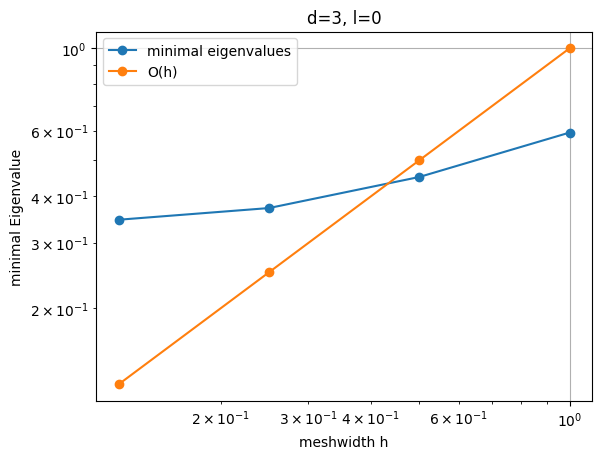

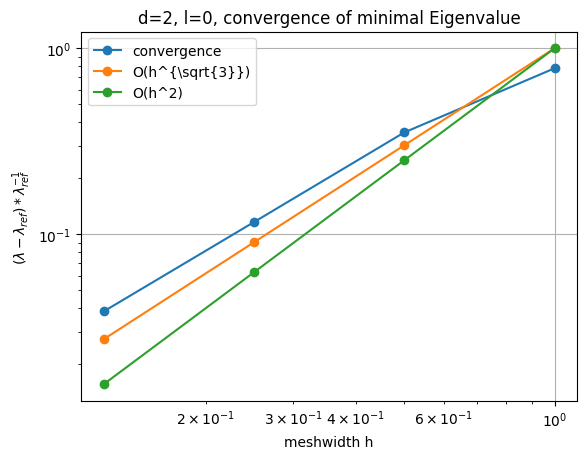

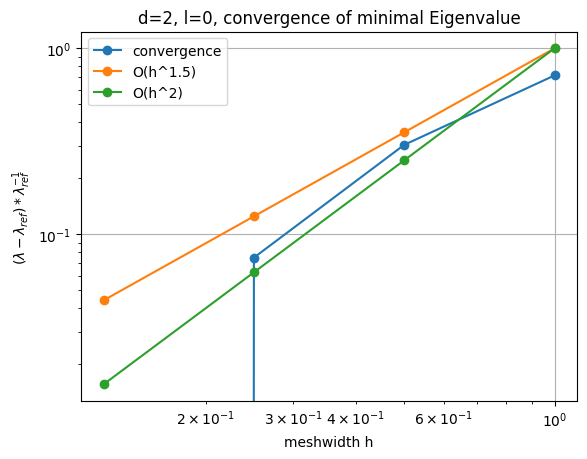

In [2]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

meshwidths = np.array([1.0,0.5,0.25,0.125]) 
l = len(meshwidths)
minEV = np.zeros(len(meshwidths))

k = 0

netgen_mesh =unit_cube.GenerateMesh(maxh=1)
mesh=Mesh(netgen_mesh)

for h in meshwidths:
    print("h=",h, "\n")
    #Draw(mesh)

    #set function space
    H_h = Compress(H1(mesh, order = 1, complex=True)) # main function space
    H_H = Compress(H1(mesh, order = 2, complex=True)) # high order Function space for Riesz representative 
    
    #low order
    u_h = H_h.TrialFunction() # define the trial function
    v_h = H_h.TestFunction() # define the test function
    #High order
    u_H = H_H.TrialFunction() # define the trial function
    v_H= H_H.TestFunction() # define the test function

    m = BilinearForm(H_h) #define m with the L2 inner product on the low order space
    m += u_h*v_h * dx 
    m.Assemble()

    a = BilinearForm(H_H) # define the H1 inner product on the high order space
    a += grad(u_H) * grad(v_H) * dx
    a += u_H*v_H * dx 
    a.Assemble()


    #mass matrix with mixed basis functions
    a_mixed = BilinearForm(trialspace=H_h, testspace=H_H)
    a_mixed += u_h*v_H*dx
    a_mixed.Assemble()

    #compute inverses 
    a_inv = a.mat.Inverse(freedofs=H_H.FreeDofs())

    m_inv = m.mat.Inverse(freedofs=H_h.FreeDofs())

    #create Matrices for GEV problem

    #c is the low order galerkin matrix
    c = BilinearForm(H_h)
    c += grad(u_h) * grad(v_h) * dx
    c += u_h*v_h * dx 
    c.Assemble()

    #faster, but might give problems
    # m==m.t
    b = c.mat.T @m_inv.T @ a_mixed.mat.T @ a_inv @ a_mixed.mat @ m_inv @ c.mat
    B = b.ToDense().NumPy()

    C = c.mat.ToDense().NumPy()
    
    #For dense calc in Numpy
    # M = m.mat.ToDense().NumPy()
    # A_inv = a_inv.ToDense().NumPy()
    # T = t.ToDense().NumPy()

    # #M == M.T 
    # B = T.T @ M.T @ A_inv @ M @ T

    EV = sp.sparse.linalg.eigs(C, k=1, M=B, which='SM', return_eigenvectors=False)
    print(EV)
    lam_abs = np.abs(EV)
    print(lam_abs)
    minEV[k] = lam_abs[0] 

    #iteration update
    k = k + 1
    #uniformly refines mesh, halving meshwidth
    mesh.Refine()
    print("\n")

fig, ax = plt.subplots()
plt.grid(visible=True)
plt.loglog(meshwidths,minEV, 'o-', label="minimal eigenvalues")
plt.loglog(meshwidths,meshwidths,'o-', label="O(h)")
# plt.loglog(meshwidths,np.power(meshwidths,2),'o-', label="O(h^2)")
# plt.loglog(meshwidths,np.power(meshwidths,3),'o-', label="O(h^3)")
# plt.loglog(meshwidths,np.power(meshwidths,4),'o-', label="O(h^4)")
plt.xlabel('meshwidth h')
plt.ylabel('minimal Eigenvalue')
plt.title('d=3, l=0')
plt.legend()
plt.show()

#convergence rate 
ref_val = 1/3

fig, ax = plt.subplots()
plt.grid(visible=True)
plt.loglog(meshwidths,(minEV - np.ones(len(meshwidths))*ref_val)/ref_val, 'o-', label="convergence")
#plt.loglog(meshwidths,np.ones(len(meshwidths)),'o-', label="O(c)")
#plt.loglog(meshwidths,meshwidths,'o-', label="O(h)")
plt.loglog(meshwidths,np.power(meshwidths,1.5),'o-', label="O(h^1.5)")
plt.loglog(meshwidths,np.power(meshwidths,2),'o-', label="O(h^2)")
#plt.loglog(meshwidths,np.power(meshwidths,3),'o-', label="O(h^3)")
#plt.loglog(meshwidths,np.power(meshwidths,4),'o-', label="O(h^4)")
plt.xlabel('meshwidth h')
plt.ylabel(r'$ (\lambda - \lambda_{ref}) * \lambda_{ref}^{-1} $')
plt.title('d=2, l=0, convergence of minimal Eigenvalue')
plt.legend()
plt.show()

#convergence rate 
ref_val = minEV[l-1]

fig, ax = plt.subplots()
plt.grid(visible=True)
plt.loglog(meshwidths,(minEV - np.ones(len(meshwidths))*ref_val)/ref_val, 'o-', label="convergence")
#plt.loglog(meshwidths,np.ones(len(meshwidths)),'o-', label="O(c)")
#plt.loglog(meshwidths,meshwidths,'o-', label="O(h)")
plt.loglog(meshwidths,np.power(meshwidths,1.5),'o-', label="O(h^1.5)")
plt.loglog(meshwidths,np.power(meshwidths,2),'o-', label="O(h^2)")
#plt.loglog(meshwidths,np.power(meshwidths,3),'o-', label="O(h^3)")
#plt.loglog(meshwidths,np.power(meshwidths,4),'o-', label="O(h^4)")
plt.xlabel('meshwidth h')
plt.ylabel(r'$ (\lambda - \lambda_{ref}) * \lambda_{ref}^{-1} $')
plt.title('d=2, l=0, convergence of minimal Eigenvalue')
plt.legend()
plt.show()
